In [193]:
# download libraries useful for the project
import pandas as pd
import numpy as np
import tensorflow as tf

from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve, f1_score, ConfusionMatrixDisplay, auc, precision_score, recall_score, accuracy_score, roc_curve
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import make_pipeline
from sklearn.utils.class_weight import compute_class_weight

from keras.layers import Embedding, LSTM, Dense, Dropout
from keras.preprocessing.text import Tokenizer
from keras.metrics import Recall, Precision, BinaryAccuracy
from keras.models import Sequential, load_model
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint
from keras.optimizers import Adam
from keras.utils import pad_sequences, plot_model

from lime.lime_text import LimeTextExplainer

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go

import joblib

In [194]:
# dowload data from cvs file
dataset = pd.read_csv("spam.csv", encoding = "ISO-8859-1") # change the default encoding which generated an error
dataset.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


### 1 - Some informations about the dataset

In [195]:
print("the dataset is composed of {} rows and {} columns.".format(dataset.shape[0],dataset.shape[1]))

the dataset is composed of 5572 rows and 5 columns.


The last three columns have a lot of empty values. We will have a look at the kind of data they have.

In [196]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   v1          5572 non-null   object
 1   v2          5572 non-null   object
 2   Unnamed: 2  50 non-null     object
 3   Unnamed: 3  12 non-null     object
 4   Unnamed: 4  6 non-null      object
dtypes: object(5)
memory usage: 217.8+ KB


It is text.
The initial message has been sliced in a few columns while downloading it because of the delimiter "," which is also inside sentences.
Let's join these columns in order to get the initial messages.

In [197]:
# let's see examples
dataset.loc[dataset["Unnamed: 2"].notnull(), :].head(10)

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
95,spam,Your free ringtone is waiting to be collected....,PO Box 5249,"MK17 92H. 450Ppw 16""",NaN
281,ham,\Wen u miss someone,the person is definitely special for u..... B...,why to miss them,"just Keep-in-touch\"" gdeve.."""
444,ham,\HEY HEY WERETHE MONKEESPEOPLE SAY WE MONKEYAR...,HOWU DOIN? FOUNDURSELF A JOBYET SAUSAGE?LOVE ...,NaN,NaN
671,spam,SMS. ac sun0819 posts HELLO:\You seem cool,"wanted to say hi. HI!!!\"" Stop? Send STOP to ...",NaN,NaN
710,ham,Height of Confidence: All the Aeronautics prof...,"this wont even start........ Datz confidence..""",NaN,NaN
899,spam,Your free ringtone is waiting to be collected....,PO Box 5249,"MK17 92H. 450Ppw 16""",NaN
1038,ham,"Edison has rightly said, \A fool can ask more ...",GN,GE,"GNT:-)"""
1127,ham,"Height of \Oh shit....!!\"" situation: A guy th...",".;-):-D""",NaN,NaN
1266,ham,\Hey sorry I didntgive ya a a bellearlier hunny,just been in bedbut mite go 2 thepub l8tr if u...,NaN,NaN
1384,ham,"Storming msg: Wen u lift d phne, u say \HELLO\...","bt not his girlfrnd... G o o d n i g h t . . .@""",NaN,NaN


In a fisrt time, we will replaced the "nan" values in these three last columns by empty. 
It will allows us to apply the str.cat method in order to group them with the column "v2".

In [198]:
for name_column in dataset.iloc[:,2:].columns :
    dataset[name_column] = dataset[name_column].fillna("")

In [199]:
# str.cat = Concatenates strings with given separator
dataset["v2"] = dataset["v2"].str.cat([dataset["Unnamed: 2"], dataset["Unnamed: 3"], dataset["Unnamed: 4"]], sep=",")
dataset.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",,,
1,ham,"Ok lar... Joking wif u oni...,,,",,,
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,,,
3,ham,U dun say so early hor... U c already then say...,,,
4,ham,"Nah I don't think he goes to usf, he lives aro...",,,


In [200]:
dataset.iloc[95,1] # check on the row 95. it is composed by the text being before in the columns "v2", "Unnamed: 2" et "Unnamed: 3"

'Your free ringtone is waiting to be collected. Simply text the password \\MIX\\" to 85069 to verify. Get Usher and Britney. FML, PO Box 5249, MK17 92H. 450Ppw 16",'

We will now simplify the dataset by deleting the useless columns.

In [201]:
dataset = dataset.iloc[:,0:2]
dataset.head()

,v1,v2
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,"Ok lar... Joking wif u oni...,,,"
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


We will also rename the columns

In [202]:
# Renaming v1 & v2 as Category & Text
dataset=dataset.rename(columns={"v1":"category","v2":"text"})

We will now look at the balance of our dataset.
It contains approximately 13.4% spam in the dataset => the dataset is unbalanced which should lead us to be vigilant in its use.

A model that only predicted normal "ham" type emails (dummy model) would display an accuracy of more than 86% on average without being relevant.

We will therefore rebalance the dataset using the class weight method a little later (when training the model with deep learning model).
With our first model, we just set the good metrics to evaluate performance of our model.
It would also be possible to use other methods.

a. keep all emails classified as spam, and at the same time reduce the number of rows with ham emails in order to have at least the same number of rows. The collateral damage will be that this will significantly reduce the size of our dataset.

b. use bootstrapping techniques like :
- Under-sample Majority Class : Randomly remove samples from the majority class to balance the class distribution.
- Over-sample Minority Class: Randomly duplicate samples from the minority class or generate synthetic samples to balance the class distribution.
- Bootstrapped Ensemble: Create multiple datasets using bootstrapping and train a model on each. The final prediction is an ensemble of these models.

In [203]:
dataset["category"].value_counts() * 100 / dataset.shape[0]

category
ham     86.593683
spam    13.406317
Name: count, dtype: float64

Finally, the target variable is currently text (ham or spam). We will transform it into an integer so that it can be used in the model.
This will be done simply by assigning the number 1 for spam, and 0 for ham.

In [204]:
# encoding with a simple lambda function and assigning the result to the same column
dataset["category"] = dataset["category"].apply(lambda x : 0 if x=="ham" else 1)

In [205]:
# see the job done
dataset.head()

,category,text
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,"Ok lar... Joking wif u oni...,,,"
2,1,Free entry in 2 a wkly comp to win FA Cup fina...
3,0,U dun say so early hor... U c already then say...
4,0,"Nah I don't think he goes to usf, he lives aro..."


### 2 - Sampling

The dataset is divided into 2 sets of data:

- Training Data: The dataset upon which the model would be trained on. Contains 80% data.
- Test Data: The dataset upon which the model would be tested against. Contains 20% data.

In [206]:
# creation of 4 datasets (2 for the features and 2 for the target) by assigning 20% ​​of the data to the validation set using test_size
# we specify a random_state value in order to be able to repeat exercice with same dataset
# stratify will help us to have the same proportion 
X_train, X_test, y_train, y_test = train_test_split(dataset["text"],
                                                    dataset["category"],
                                                    test_size = 0.2,
                                                    stratify = dataset["category"],
                                                    random_state = 90)

In [207]:
# let's have a look at the feature for training
X_train

2963    Do you ever notice that when you're driving, a...
4705    Wow so healthy. Old airport rd lor. Cant thk o...
4606    Been running but only managed 5 minutes and th...
4514    That was random saw my old roomate on campus. ...
935                         Then dun wear jeans lor...,,,
                              ...                        
1463    Ok good then i later come find Ì_... C lucky i...
4231                          I'm at home. Please call,,,
3618    8007 25p 4 Alfie Moon's Children in Need song ...
2969                           U should make a fb list,,,
5099    Ah, well that confuses things, doesnt it? I th...
Name: text, Length: 4457, dtype: object

### 3 - Text preprocessing

We will use spacy to clean and normalize the text.
Spacy is a free open-source library for Natural Language Processing in Python.

In [208]:
# installation of library spacy with pre-trained model in English, and small english pipeline (sm) for small text size.
!python -m spacy download en_core_web_sm -q

✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [209]:
# download pre-trained model and instantiate it
import en_core_web_sm
nlp = en_core_web_sm.load()

In [210]:
# download stop words list (common words in english which are not relevant and not discriminating)
from spacy.lang.en.stop_words import STOP_WORDS

Creation of a function to preprocess the text.

In [211]:
def text_preprocessing(dataset) :
    """_summary_
    function used to preprocess a text column :
    - removes non alphanumeric characters
    - lowercases all words
    - removes leading and trailing whitespaces from the string
    - replaces words with its lemma
    - removes stop words
    - reconstructs sentence
    Args:
        dataset with one column to be preprocessed
    Returns:
        dataset with initial column preprocessed
    """
    # remove all characters that are not alphanumeric, except spaces
    dataset = dataset.apply(lambda x:"".join(ch for ch in x if ch.isalnum() or ch==" "))

    # replace(" +"," ") = removes double or more spaces at the beginning and end of words, by an unique space
    # lower = lowercases all words
    # strip = removes leading and trailing whitespaces from the string
    dataset = dataset.apply(lambda x: x.replace(" +"," ").lower().strip())

    # nlp(x) = Applies spaCy's NLP model to tokenize and analyze the text
    # token.lemma_ = for each token in nlp(x), replaces it by its lemma
    # removal of stop words
    # " ".join = reconstruction of sentences by grouping words with a space between
    dataset = dataset.apply(lambda x: " ".join([token.lemma_ for token in nlp(x) if (token.lemma_ not in STOP_WORDS) & (token.text not in STOP_WORDS)]))
    return dataset

Applying our function to column “text” of our feature dataset

In [212]:
X_train_prep = text_preprocessing(X_train)
X_test_prep = text_preprocessing(X_test)

Check of the preprocessing job

In [213]:
X_train_prep.head()

2963            notice drive slow idiot drive fast maniac
4705    wow healthy old airport rd lor thk ill b bathe...
4606    run manage 5 minute need oxygen resort roller ...
4514                   random old roomate campus graduate
935                                    dun wear jeans lor
Name: text, dtype: object

Vectorization

In [214]:
# Instantiate a TF-IDF vectorizer
# TF-IDF means term frequency and inverse document frequency.
# It is used to tokenize the documents, learn the vocabulary, and inverse the document frequency weightings
# it creates a matrix TF-IDF
tfidf_vectorizer = TfidfVectorizer()

# Fitting training data with the vectorizer
tfidf_vectorizer.fit(X_train_prep)

# Get features names. Features names here are the words in the corpus vocabulary
tfidf_features = tfidf_vectorizer.get_feature_names_out()
print("Number of features in the vocabulary : ", len(tfidf_features))

Number of features in the vocabulary :  7266


In [215]:
# Use transform method to transform train and test set with our vectorizer fitted
# TfidfVectorizer will converts sets into a matrix of TF-IDF features.
X_train_lr = tfidf_vectorizer.transform(X_train_prep)
X_test_lr  = tfidf_vectorizer.transform(X_test_prep)

In [216]:
# sparse matrix is an optimised type of matrix when a lot of values are zero.
X_train_lr

<4457x7266 sparse matrix of type '<class 'numpy.float64'>'
	with 31796 stored elements in Compressed Sparse Row format>

### 3 - Base model

##### 3.1 Train the model

In [217]:
# Instantiate the LR model
# we define the parameter C at 2 (inverse of regularization strength - smaller values specify stronger regularization)
# and a number of iteration to converge of 1000
# for a first try we decided to not specified others hyperparameters (solver and penalty for example)
model_lr = LogisticRegression(C = 2, max_iter = 1000)

# Call the fit method to train the model
model_lr.fit(X_train_lr, y_train)

LogisticRegression(C=2, max_iter=1000)

In [218]:
# make prediction on test set
y_pred_lr = model_lr.predict(X_test_lr)

In [219]:
# get the probabilities for each prediction
pred_prob = model_lr.predict_proba(X_test_lr)

In [220]:
# predict_proba return a list with two values for each sentences
# probabilities to be ham, and spam. Sum is 1
pred_prob

array([[0.13290395, 0.86709605],
       [0.86704237, 0.13295763],
       [0.97268041, 0.02731959],
       ...,
       [0.97117485, 0.02882515],
       [0.94877728, 0.05122272],
       [0.96530808, 0.03469192]])

In [221]:
# for example purpose, score() returns the mean accuracy, on test set in this case
# as explained before, due to an unbalanced dataset, this metric won't be the best way to evaluate performance of our model
print("the accuracy on test set is : ",model_lr.score(X_test_lr, y_test).round(4))

the accuracy on test set is :  0.9758


##### 3.2 AUC Score & ROC Curve

Plot ROC Curve (Receiver Operating Characteristic)

It shows the performance of a binary classifier with different decision thresholds. It plots the True Positive rate (TPR, also recall) against the False Positive rate (FPR).
- TPR = True Positives / (True Positives + False Negatives)
- FPR = False Positives / (False Positives​ + True Negatives)

In [222]:
# get fpr and tpr. Returns also the treshold but we don't need it (__)
fpr,tpr,__ = roc_curve(y_test, pred_prob[:,1])

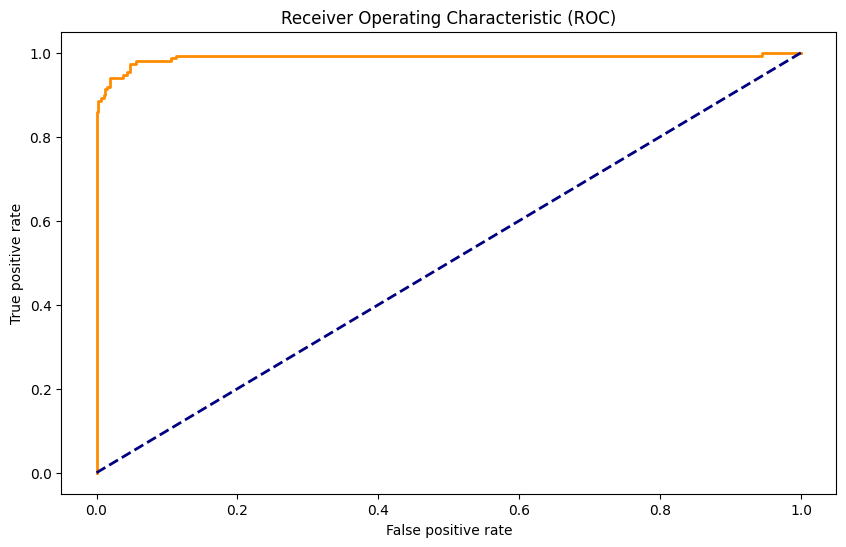

In [223]:
# Visualization ROC curve
plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, color="darkorange", lw=2)
plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
plt.xlabel("False positive rate")
plt.ylabel("True positive rate")
plt.title("Receiver Operating Characteristic (ROC)")
plt.show()

Compute AUC Score

ROC AUC is the area under the ROC curve.

It sums up how well a model can produce relative scores to discriminate between positive or negative instances across all classification thresholds

A score very closed to 1 is a very good performance.

In [224]:
# Compute AUC score
auc_score = roc_auc_score(y_test,y_pred_lr)
print("ROC AUC score : ", round(auc_score, 3))

ROC AUC score :  0.912


##### 3.3 Confusion matrix & Classification report

In [225]:
print(classification_report(y_test,y_pred_lr, target_names=["Ham","Spam"]))

              precision    recall  f1-score   support

         Ham       0.97      1.00      0.99       966
        Spam       0.99      0.83      0.90       149

    accuracy                           0.98      1115
   macro avg       0.98      0.91      0.94      1115
weighted avg       0.98      0.98      0.97      1115



This report gives us informations about classification's performance of our model, for each category first (ham or spam).
For example :
- 99% of Spam detected by our model were really spam (precision / spam)
- but 83% of real spams were detected by our model (recall / spam)
- to conclude, the F1 score, which computes the two ratios above, is about 90% on spam.

A reminder :
- Precision: Percentage of correct positive predictions relative to total positive predictions.
- Recall: Percentage of correct positive predictions relative to total actual positives.
- F1 score : A weighted harmonic mean of precision and recall (2 * (Precision * Recall) / (Precision + Recall))

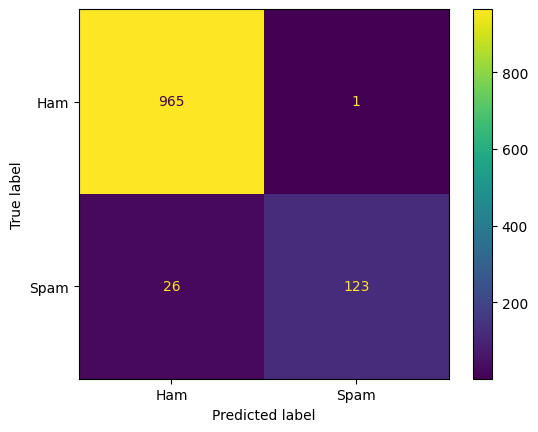

In [226]:
# we visualize the confusion matrix
cf_matrix = confusion_matrix(y_test, y_pred_lr)
fig = ConfusionMatrixDisplay(cf_matrix, display_labels=["Ham", "Spam"])
fig.plot()
plt.show()

Some explainations :
- our model made one error to predict correct true ham wich is really good (false positive).
- but its ability to predict spam is less good with 30 errors (false negative).

As shown on the classification report above, the recall on spam is around 83% wich is not really high regarding the recall on ham (100%).
But for both spam and ham, the precision is very good.

Let's save the performance in a dataframe

In [227]:
# calculate some metrics
f1_score_lr = f1_score(y_test, y_pred_lr)
recall = recall_score(y_test, y_pred_lr)
precision = precision_score(y_test, y_pred_lr)

In [228]:
# dataframe with metrics
model_results = pd.DataFrame({"F1 score" : f1_score_lr.round(4),
                              "Recall" : recall.round(4),
                              "Precision" : precision.round(4),
                              "AUC Score" : auc_score},
                             index=["Logistic regression"])

In [229]:
model_results

,F1 score,Recall,Precision,AUC Score
Logistic regression,0.9011,0.8255,0.9919,0.912234


##### 3.4 Feature importance

In [230]:
# Get the list of the model coefficients in absolute value in order to see the main words which are important
# model_lr.coef_ gives a list inside a list, that's why we use [0]
importance_list = abs(model_lr.coef_[0])

# Transform the list and features names in Pandas dataframe
# list() creates a list with both the features names and the coefficients (see above) which are zipped
importance_df = pd.DataFrame(list(zip(tfidf_features, importance_list)),
               columns =["Word", "Importance"]).sort_values(by=["Importance"], ascending=False)

# Display the dataframe
importance_df

,Word,Importance
6552,txt,6.002750
6930,win,4.846821
1752,claim,4.835387
4262,mobile,4.390155
5620,service,4.357182
...,...,...
6171,sympathetic,0.000892
5150,psychologist,0.000892
3893,listener,0.000892
1839,companion,0.000892


Explain classification of one email (thanks to Sitou for his help, he shows us this tools)

In [231]:
# Let's instantiate the LIME text explainer
CLASSES_LIST = ["Ham", "Spam"]
explainer = LimeTextExplainer(class_names=CLASSES_LIST)

In [232]:
# Let's create the processing pipeline with both the model and the preprocessing
processing_pipeline = make_pipeline(tfidf_vectorizer, model_lr)

In [233]:
# ID of the tweet in the test set
idx = 47

# Call the explainer for the specific tweet
exp = explainer.explain_instance(list(X_test)[idx], # choose an email from the list on test set
                                 processing_pipeline.predict_proba, # predict classification applying the pipeline
                                 num_features=8) # use at most 8 features to explain prediction

# Print true label
print("True class: %s" % CLASSES_LIST[list(y_test)[idx]])

# Show results
exp.show_in_notebook(text=True)

True class: Ham


In [234]:
# save the model
joblib.dump(model_lr, "model_lr.joblib")

['model_lr.joblib']

At this part, we decided not to try to improve this first model, as performance looks great.

We could try to manage hyperparameters :
- change value of C
- work on others hyperparameters :
    - penalty : norm of the penalty used (regularisation)
    - solver : Algorithm to use in the optimization problem

### 4 - LSTM model

##### 4.1 Tokenization

Tokenization of the text which leads of encoding it in the form of a list of numbers, a word being represented by a unique value.

In [235]:
tokenizer_lstm = Tokenizer() # instanciate the tokenizer
tokenizer_lstm.fit_on_texts(X_train) # applying tokenizer to X_train in order to create a dictionary for the entire corpus (a mapping of each word token and its unique integer index)
X_train_tok = tokenizer_lstm.texts_to_sequences(X_train) # convert words in each corpus text into integer sequences, for train set
X_test_tok = tokenizer_lstm.texts_to_sequences(X_test) # idem for test set

In [236]:
# let's see the result for one word
X_train_tok[0]

[33,
 3,
 336,
 1432,
 20,
 46,
 264,
 638,
 610,
 73,
 3853,
 368,
 3,
 9,
 116,
 1658,
 7,
 666,
 638,
 1993,
 368,
 3,
 9,
 4,
 3854]

##### 4.2 Padding

This allows:
- to standardize the length of lists by adding 0s at the start (pre) or end of the list (post)
- to transform the encoded text column into a numpy array

In [237]:
# we set a "post padding" (0 at the end)
# and a maximum length of 30 characters as we are working with email (short sentences, and small words in general)
X_train_pad =pad_sequences(X_train_tok, padding="post", maxlen=30)
X_test_pad =pad_sequences(X_test_tok, padding="post", maxlen=30)

In [238]:
# Print the shape
print("Train X Shape:",X_train_pad.shape)
print("Test X Shape:",X_test_pad.shape)

Train X Shape: (4457, 30)
Test X Shape: (1115, 30)


In [239]:
# let's see the work done
X_train_pad

array([[  33,    3,  336, ...,    0,    0,    0],
       [ 937,   22, 3855, ...,    0,    0,    0],
       [ 101, 1142,   25, ...,    0,    0,    0],
       ...,
       [  43, 2314, 2315, ..., 1888,   18, 1034],
       [   6,  143,  148, ...,    0,    0,    0],
       [8011,  259, 1237, ...,  181,   14,  245]])

##### 4.3 Create model

In our base model, we will use an RNN which is most suitable for NLP (ideal for sequential data).
Indeed, this kind of model has the capacity to use precedent inputs.

We used :
- an embedding layer : This layer converts integer-coded words into dense vectors of fixed size. It helps in representing words in a continuous vector space, capturing semantic relationships.
- an LSTM layer : LSTMs are effective for capturing long-term dependencies in sequential data.
- a Dense layer : A fully connected layer, adding further complexity to the model.
- an output layer with a sigmoid activation function, relevant with this classification exercise
- between each layer above, we used a dropout layer with .2 as parameter. It randomly sets input units to 0 with a frequency of rate at each step during training time, which helps prevent overfitting. 

In [240]:
# Get the vocabulary size which will be used as a parameter in the first layer of our model
word_index = tokenizer_lstm.word_index
vocab_size = len(word_index)
print("Vocabulary Size :", vocab_size)

Vocabulary Size : 8011


In [241]:
# overview of word_index which is a dictionnary with words and their index
word_index

{'i': 1,
 'to': 2,
 'you': 3,
 'a': 4,
 'the': 5,
 'u': 6,
 'and': 7,
 'in': 8,
 'is': 9,
 'me': 10,
 'my': 11,
 'for': 12,
 'your': 13,
 'of': 14,
 'it': 15,
 'call': 16,
 'have': 17,
 '2': 18,
 'on': 19,
 'that': 20,
 'now': 21,
 'so': 22,
 'not': 23,
 'are': 24,
 'but': 25,
 'or': 26,
 'at': 27,
 'ur': 28,
 "i'm": 29,
 'can': 30,
 'will': 31,
 'with': 32,
 'do': 33,
 'get': 34,
 'be': 35,
 'just': 36,
 'if': 37,
 'we': 38,
 'no': 39,
 'this': 40,
 'gt': 41,
 'lt': 42,
 '4': 43,
 'up': 44,
 'how': 45,
 'when': 46,
 'ok': 47,
 'all': 48,
 'go': 49,
 'like': 50,
 'from': 51,
 'free': 52,
 'out': 53,
 'know': 54,
 'what': 55,
 'then': 56,
 'good': 57,
 'come': 58,
 'got': 59,
 'was': 60,
 'time': 61,
 'its': 62,
 'am': 63,
 'day': 64,
 'love': 65,
 'only': 66,
 'he': 67,
 'send': 68,
 'there': 69,
 'text': 70,
 'want': 71,
 'as': 72,
 'going': 73,
 'txt': 74,
 'by': 75,
 'lor': 76,
 'about': 77,
 'need': 78,
 'one': 79,
 'our': 80,
 'sorry': 81,
 "i'll": 82,
 'stop': 83,
 'today': 84,
 

In [242]:
# definition of the number of output dimensions of the 1st layer
# we start with a medium size.
# it depends on vocabulary size, task complexity, relationship between words
embeded_dim = 20

# creation of the model using sequential method
model_lstm = Sequential([
                  # Word Embedding layer
                  Embedding(input_dim=vocab_size+1, output_dim=embeded_dim, input_length=X_train_pad.shape[1],name="embedding"), # output is a tensor of shape (batch, input_lenght, output_dim)
                  Dropout(.2),
                  # LSTM layer that returns only the last output
                  LSTM(units=150, name="lstm"),
                  Dropout(.2),
                  # Dense layer
                  Dense(32),
                  Dropout(.2),
                  # output layer with one neuron to be relevant with a binary classification, and a sigmoid activation function
                  Dense(1, activation="sigmoid")
])

In [243]:
# visualization of our model in a synthetic way
model_lstm.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 30, 20)            160240    
                                                                 
 dropout_41 (Dropout)        (None, 30, 20)            0         
                                                                 
 lstm (LSTM)                 (None, 150)               102600    
                                                                 
 dropout_42 (Dropout)        (None, 150)               0         
                                                                 
 dense_4 (Dense)             (None, 32)                4832      
                                                                 
 dropout_43 (Dropout)        (None, 32)                0         
                                                                 
 dense_5 (Dense)             (None, 1)                

Addition to our model of an optimization algorithm, a cost function and performance metrics:
- the optimization algorithm chosen is the most common (Adam).
- the loss function is quite classically the BinaryCrossentropy which is adapted to our problem.
- given the nature of the problem (binary classification), we have completed the criteria for measuring the performance of the model. To accuracy we therefore added recall, precision.

In our example, the positive values correspond to ham emails.

Recall: measures the percentage of positives well predicted by our model, compared to all positives. Recall then reflects the ability of our model to correctly predict that an email is true. When the recall is high, it means that it will not miss any positives. However, this does not give any information on its prediction quality on negatives.

Precision: also measures the percentage of positives well predicted by our model, compared to all predicted positives. This is quite similar to the Recall. The difference is in the denominator of the ratio which takes into account false positives. When the precision is high, it means that the majority of positive predictions are well predicted positives.

These two indicators are relevant if we take them in combination, which will be the case with the F1 score that we will calculate afterwards.

In [244]:
# Set the optimizer used
OPTIMIZER = Adam()

# Set the metrics used
METRICS = [
    BinaryAccuracy(name="accuracy"),
    Recall(name="recall"),
    Precision(name="precision")
]

# compil our model, and specify the loss function
model_lstm.compile(optimizer=OPTIMIZER,
              loss= "binary_crossentropy",
              metrics=METRICS
              )

Use of Call back in order to :
- save the best model during the fitting , even before the end of the job
- reduce learning rate when loss on validation set doesn't change

In [245]:
mc = ModelCheckpoint("best_model.h5", monitor="val_loss", mode="min", verbose=0, save_best_only=True)
lr = ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=3, min_lr=0.0001)

As mentioned during the part on the exploratory of the dataset. The unbalanced nature of the dataset is problematic.

We will therefore use a sklearn function (compute class weight) which will rebalance our dataset when training the model.

In [246]:
# calculation of the weights to be assigned to each class
# class_weight="balanced" specifies the method used to compute class weights.
# "balanced" indicates that the weights should be computed inversely proportional to class frequencies, aiming to balance the contribution of each class.
class_weights = compute_class_weight(class_weight="balanced", classes=np.unique(y_train), y=y_train)
class_weights_dict = dict(zip(np.unique(y_train), class_weights))

Training of the model on the training batches, and validation of the results on the validation batches

In [247]:
# we chose 20 epochs and a batch size of 64
# epoch : number of time all the dataset is seen by the model
# batch_size : number of samples we send to the model at a time
# model results are assigned to a variable
lstm_history = model_lstm.fit(X_train_pad, y_train,
                              batch_size=64,
                              epochs=20,
                              class_weight=class_weights_dict,
                              callbacks=[mc,lr],
                              validation_data=(X_test_pad, y_test))


Epoch 1/20


70/70 [==============================] - 8s 68ms/step - loss: 0.3034 - accuracy: 0.9080 - recall: 0.8361 - precision: 0.6158 - val_loss: 0.1552 - val_accuracy: 0.9731 - val_recall: 0.9664 - val_precision: 0.8521 - lr: 0.0010
Epoch 2/20
70/70 [==============================] - 4s 53ms/step - loss: 0.0920 - accuracy: 0.9798 - recall: 0.9599 - precision: 0.8969 - val_loss: 0.0388 - val_accuracy: 0.9892 - val_recall: 0.9530 - val_precision: 0.9660 - lr: 0.0010
Epoch 3/20
70/70 [==============================] - 3s 48ms/step - loss: 0.0234 - accuracy: 0.9951 - recall: 0.9900 - precision: 0.9737 - val_loss: 0.0333 - val_accuracy: 0.9892 - val_recall: 0.9597 - val_precision: 0.9597 - lr: 0.0010
Epoch 4/20
70/70 [==============================] - 3s 47ms/step - loss: 0.0097 - accuracy: 0.9975 - recall: 0.9967 - precision: 0.9851 - val_loss: 0.0730 - val_accuracy: 0.9830 - val_recall: 0.8859 - val_precision: 0.9851 - lr: 0.0010
Epoch 5/20
70/70 [==============================] - 3s 48ms/step - 

We will now look at what the results of our model are at the end of the epochs

In [248]:
def evaluation_model(model_name) :
    """_summary_
    print for each metric of the model their value
    Args:
        name of the model goven when training it
    """
    model_name_evaluation = model_name.evaluate(X_test_pad, y_test)
    print("Validation Loss:", round(model_name_evaluation[0],4))
    print("Validation Accuracy:", round(model_name_evaluation[1],4))
    print("Validation Recall:", round(model_name_evaluation[2],4))
    print("Validation Precision:", round(model_name_evaluation[3],4))

evaluation_model(model_lstm)

 4/35 [==>...........................] - ETA: 0s - loss: 0.1428 - accuracy: 0.9844 - recall: 0.9048 - precision: 1.0000    

35/35 [==============================] - 1s 14ms/step - loss: 0.1346 - accuracy: 0.9821 - recall: 0.8792 - precision: 0.9850
Validation Loss: 0.1346
Validation Accuracy: 0.9821
Validation Recall: 0.8792
Validation Precision: 0.985


It is also interesting to look at how these performance indicators evolve over time.
To do this, we will graphically visualize the results at each epoch, using the matplotlyt library, for both the training and the test set.

We will encapsulate the code within a function which will later allow it to be easily reused for other models.

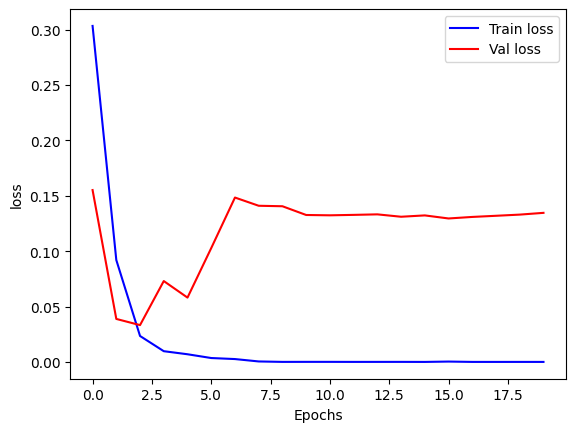

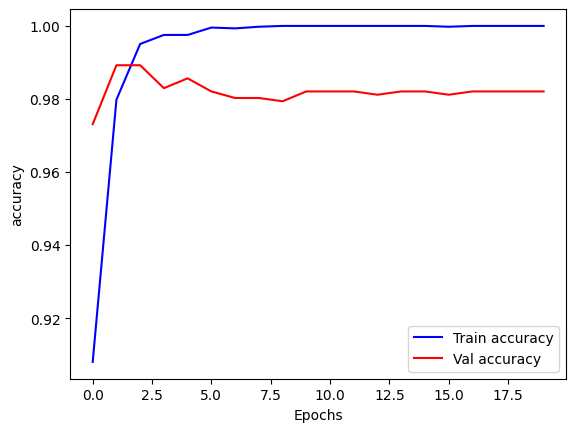

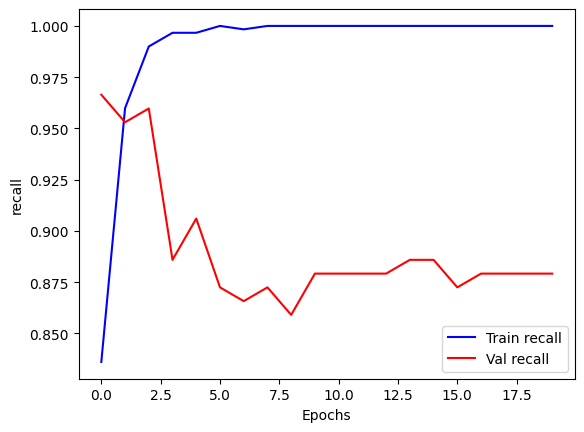

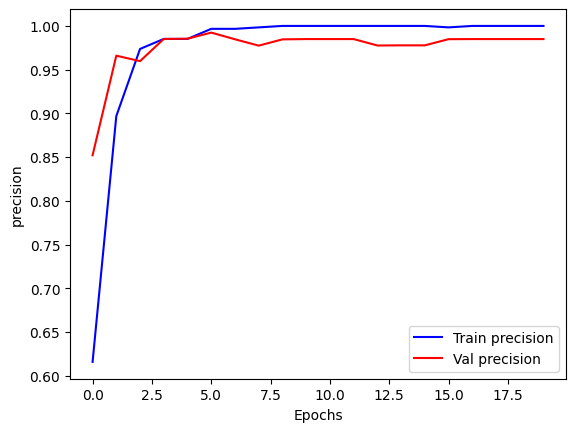

In [249]:
def indicators_visualization(model_history) :
    """_summary_
    visualize performance indicators for each epoch
    Args:
        name of the model used to train the model
    """
    for indicator in ["loss", "accuracy", "recall", "precision"] :
        plt.plot(model_history.history[indicator], color="b", label="Train "+indicator)
        plt.plot(model_history.history["val_"+indicator], color="r", label = "Val "+indicator)
        plt.ylabel(indicator)
        plt.xlabel("Epochs")
        if indicator == "loss" :
            plt.legend(loc = "upper right")
        else :
            plt.legend(loc = "lower right")
        plt.show()

indicators_visualization(lstm_history)

As we can see :
- performances on train set are better than on validation set, which is usual
- performances of our model on validation set aren't the best ones at the end of all the epochs.

In our example, changes are not always significant (pay attention to the scale), but we could choose to retain a model at a specific epoch, before the end.

let's have a look at the performance of our model saved with the callback.

In [250]:
# download the model saved during the fitting
best_model_lstm = load_model("best_model.h5")

In [251]:
# see performance of this model which should be the best one
evaluation_model(best_model_lstm)

35/35 [==============================] - 1s 14ms/step - loss: 0.0333 - accuracy: 0.9892 - recall: 0.9597 - precision: 0.9597
Validation Loss: 0.0333
Validation Accuracy: 0.9892
Validation Recall: 0.9597
Validation Precision: 0.9597


Comparison with the other RNN model :
- performance are globaly improved.
- it is not so significant on accuracy (ex 0.9785)
- but much more on the others metrics (recall, precision and loss)

In [252]:
# calculate predictions on test set through probabilities
y_pred_lstm = best_model_lstm.predict(X_test_pad)

35/35 [==============================] - 1s 14ms/step


In [253]:
# overview of ten prediction probabilities
y_pred_lstm[:10]

array([[9.99932826e-01],
       [9.00783855e-03],
       [1.96761524e-04],
       [1.15838472e-03],
       [9.99969542e-01],
       [2.59587803e-04],
       [1.05632455e-04],
       [3.56148160e-03],
       [5.96033372e-02],
       [9.99879479e-01]], dtype=float32)

In [254]:
# convert prediction (probabilities, float number) in integer with two values : 0 or 1.
# the threshold between 0 and 1 is the probability of 50% (.5). We could choose another value according to our goal
y_pred_lstm = (y_pred_lstm > 0.5).astype(int)

# convert y_test in integer (error with f1_score computing)
y_val = y_test.astype(int)

F1 Score : 0.9597
AUC : 0.9768


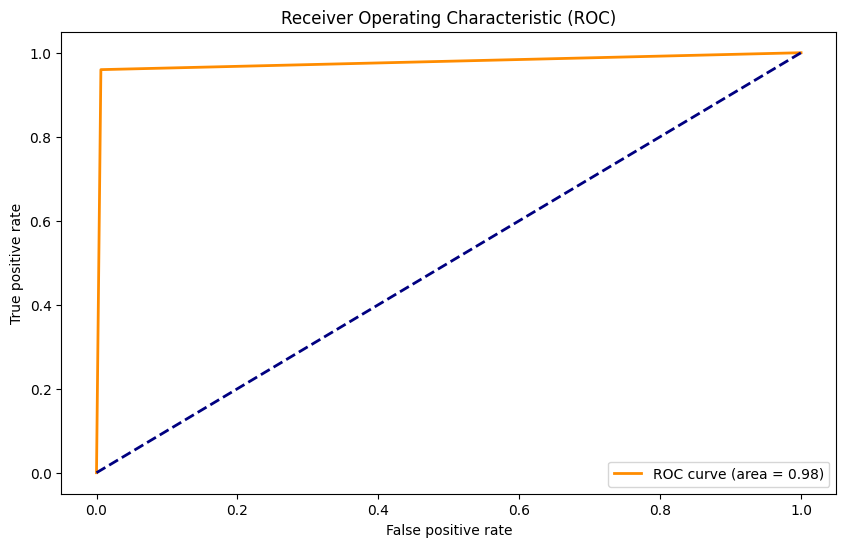

In [255]:
# compute and show F1 Score
f1score_lstm = f1_score(y_val, y_pred_lstm).round(4)
print("F1 Score : {}".format(f1score_lstm))

# compute ROC curve and AUC
fpr, tpr, __annotations__ = roc_curve(y_val, y_pred_lstm)
roc_auc = auc(fpr, tpr).round(4)

# show AUC
print("AUC : {}".format(roc_auc))

# Visualization ROC curve
plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, color="darkorange", lw=2, label="ROC curve (area = {:.2f})".format(roc_auc))
plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
plt.xlabel("False positive rate")
plt.ylabel("True positive rate")
plt.title("Receiver Operating Characteristic (ROC)")
plt.legend(loc="lower right")
plt.show()

Save metrics to our dataframe with results

In [256]:
# compute recall and precision
recall_lstm = best_model_lstm.evaluate(X_test_pad, y_test)[2]
precision_lstm = best_model_lstm.evaluate(X_test_pad, y_test)[3]

13/35 [==========>...................] - ETA: 0s - loss: 0.0570 - accuracy: 0.9856 - recall: 0.9216 - precision: 0.9592

35/35 [==============================] - 0s 13ms/step - loss: 0.0333 - accuracy: 0.9892 - recall: 0.9597 - precision: 0.9597


In [257]:
# dataframe with metrics
lstm_results = pd.DataFrame({"F1 score" : f1score_lstm.round(4),
                              "Recall" : recall_lstm,
                              "Precision" : precision_lstm,
                              "AUC Score" : round(roc_auc,4)},
                             index=["LSTM model"])

model_results = pd.concat([model_results,lstm_results])
model_results

,F1 score,Recall,Precision,AUC Score
Logistic regression,0.9011,0.825500,0.991900,0.912234
LSTM model,0.9597,0.959732,0.959732,0.976800


In [258]:
# save the model
joblib.dump(model_lstm, "model_lstm.joblib")

['model_lstm.joblib']

##### 4.4 Explication of result

In [259]:
# instantiate the LIME text explainer
explainer = LimeTextExplainer(class_names=["Ham", "Spam"])

In [260]:
def predict_class(email):
    """
    function to preprocess the text and classifiate it with an existing model (LSTM)
    Args:
        email (string): the email to classify

    Returns:
        array: np array with probabilities for both possibilities (ham and spam)
    """
    email = pad_sequences(tokenizer_lstm.texts_to_sequences([email]), padding="post", maxlen=30)
    probability_score = best_model_lstm.predict(email)[0][0]
    pred = np.array([[1.0-probability_score, probability_score]])
    return pred

In [261]:
# select an email from the list
idx = 47
text_email= list(X_test)[idx]

# Print true label
print("True class: %s" % CLASSES_LIST[list(y_test)[idx]])

# Show results
# in this case, we defined num_samples because we had an error without
exp = explainer.explain_instance(text_email, predict_class, num_features=8, num_samples=1)
exp.show_in_notebook()

True class: Ham
1/1 [==============================] - 0s 48ms/step


C:\Users\SD\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_regression.py:996: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


### 5 - Transfert learning

We will experiment in this part transfert learning with tranformers, thanks to the help of these websites :
- https://huggingface.co/
- https://www.tensorflow.org/


##### 5.1 Reminder of data that will be use

In [262]:
# reminder about the dataset
dataset.head()

,category,text
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,"Ok lar... Joking wif u oni...,,,"
2,1,Free entry in 2 a wkly comp to win FA Cup fina...
3,0,U dun say so early hor... U c already then say...
4,0,"Nah I don't think he goes to usf, he lives aro..."


In [263]:
# and the datatasets after splitting
X_test.shape, X_train.shape, y_test.shape, y_test.shape

((1115,), (4457,), (1115,), (1115,))

In [264]:
X_train.head()

2963    Do you ever notice that when you're driving, a...
4705    Wow so healthy. Old airport rd lor. Cant thk o...
4606    Been running but only managed 5 minutes and th...
4514    That was random saw my old roomate on campus. ...
935                         Then dun wear jeans lor...,,,
Name: text, dtype: object

In [265]:
y_train.head()

2963    1
4705    0
4606    0
4514    0
935     0
Name: category, dtype: int64

##### 5.2 Building the model

In [266]:
# import useful library
from transformers import BertTokenizer,TFBertModel, BertForSequenceClassification

In [267]:
# define model to use
# model BERT = Bidirectional Encoder Representations from Transformers
# uncased = model trained on lowercase text without differentiating between uppercase and lowercase letters
# base = refers to a medium-sized model in terms of parameters
MODEL_NAME = "bert-base-uncased"

In [268]:
# define a tokenizer object
tokenizer = BertTokenizer.from_pretrained(MODEL_NAME)

In [269]:
def bert_encode(input_text, max_len):
    """
    use of the method batch_encode_plus from bert model in order to encode text
    Args:
        input_text (serie): serie with original email to encode
        max_len (int): maximum size of the encoded sequence in output
    Returns:
        two tensors for 
    """
    tokens = tokenizer.batch_encode_plus(
        input_text.tolist(), # transform input in list
        add_special_tokens = True, # add specific tokens [CLS] (begining of each sequence) and [SEP] (end of each sequence)
        truncation=True, # trunc sequencies if they are longer then the max_len
        max_length = max_len, # maximal len of sequences after encoding
        padding = True, # add zero if necessary to have equal size of sequences
        return_attention_mask = True, # attention mask is a binary tensor indicating the position of the padded indices so that the model does not attend to them
    )
    return tf.convert_to_tensor(tokens["input_ids"]), tf.convert_to_tensor(tokens["attention_mask"])

In [270]:
# tokenize the text
train_encodings, train_attention = bert_encode(X_train, 30)
test_encodings, test_attention  = bert_encode(X_test, 30)

In [271]:
def create_model(bert_model):
    """_summary_

    Args:
        bert_model (_type_): _description_

    Returns:
        _type_: _description_
    """
    input_ids = tf.keras.Input(shape= (30,), dtype= "int32")
    attention_masks = tf.keras.Input(shape= (30,), dtype= "int32")
    
    # pass the input layers define above (tensors for attention mask and encoded text)
    output = bert_model([input_ids, attention_masks])
    # extract the second element of the bert model output juste above
    output = output[1]
    # first layer is a dense layer with 32 neurons
    output = tf.keras.layers.Dense(32, activation= "relu")(output)
    # use of a dropout with value 0.2 (see before for explaination
    output = tf.keras.layers.Dropout(0.2)(output)
    # last layer is a dense layer with 1 neuron suitable for classification, and sigmoid for activation
    output = tf.keras.layers.Dense(1, activation= "sigmoid")(output)
    # creation of final model using inputs and output
    model = tf.keras.models.Model(inputs= [input_ids, attention_masks], outputs= output)
    # compilation of our model with metrics, loss, and optimizer used before (see RNN model)
    model.compile(Adam(learning_rate=0.001), loss= "binary_crossentropy", metrics=[BinaryAccuracy(name="binary_accuracy"),Recall(name="recall"),Precision(name="precision")])
    return model

In [272]:
# initialisation of bert model with pretrained weights from model_name choose
# we first decided to set the params to non-trainable
bert_model = TFBertModel.from_pretrained(MODEL_NAME, trainable=False)

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

In [273]:
model = create_model(bert_model)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 30)]         0           []                               
                                                                                                  
 input_4 (InputLayer)           [(None, 30)]         0           []                               
                                                                                                  
 tf_bert_model_1 (TFBertModel)  TFBaseModelOutputWi  109482240   ['input_3[0][0]',                
                                thPoolingAndCrossAt               'input_4[0][0]']                
                                tentions(last_hidde                                               
                                n_state=(None, 30,                                          

5.3 Train the model

In [274]:
# we keep the same batch size as for our RNN model
# we use both encoded sequences and mask attention in input for our model
bert_history = model.fit(
    [train_encodings, train_attention],
    y_train, 
    epochs = 20,
    batch_size = 64,
    validation_data=([test_encodings, test_attention], y_test),
    class_weight=class_weights_dict
)

Epoch 1/20
70/70 [==============================] - 321s 4s/step - loss: 0.5600 - binary_accuracy: 0.7373 - recall: 0.7040 - precision: 0.2975 - val_loss: 0.3105 - val_binary_accuracy: 0.9309 - val_recall: 0.8658 - val_precision: 0.6935
Epoch 2/20
70/70 [==============================] - 320s 5s/step - loss: 0.3959 - binary_accuracy: 0.8553 - recall: 0.8344 - precision: 0.4775 - val_loss: 0.3571 - val_binary_accuracy: 0.8628 - val_recall: 0.9799 - val_precision: 0.4932
Epoch 3/20
70/70 [==============================] - 322s 5s/step - loss: 0.3236 - binary_accuracy: 0.8791 - recall: 0.8712 - precision: 0.5300 - val_loss: 0.2155 - val_binary_accuracy: 0.9291 - val_recall: 0.9530 - val_precision: 0.6636
Epoch 4/20
70/70 [==============================] - 316s 5s/step - loss: 0.2719 - binary_accuracy: 0.9033 - recall: 0.8913 - precision: 0.5929 - val_loss: 0.2277 - val_binary_accuracy: 0.9211 - val_recall: 0.9866 - val_precision: 0.6309
Epoch 5/20
70/70 [==============================] - 

5.4 Performance

In [275]:
# make prediction on test set
y_pred_bert = model.predict([test_encodings, test_attention])
y_pred_bert = y_pred_bert.flatten() # used to reshape the array wich was in 2 dimensions (shape 1115,1)

35/35 [==============================] - 1755s 51s/step


In [276]:
y_pred_bert = (y_pred_bert > 0.5).astype(int)
y_pred_bert

array([1, 0, 0, ..., 0, 0, 0])

F1 Score : 0.9148
AUC : 0.9768


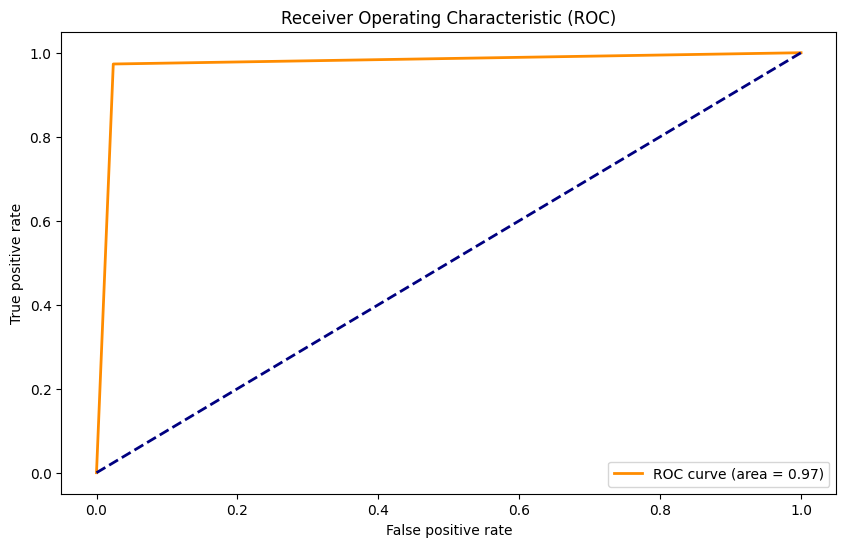

In [277]:
# compute and show F1 Score
f1score_bert = f1_score(y_test, y_pred_bert).round(4)
print("F1 Score : {}".format(f1score_bert))

# compute ROC curve and AUC
fpr, tpr, __annotations__ = roc_curve(y_test, y_pred_bert)
roc_auc_bert = auc(fpr, tpr).round(4)

# show AUC
print("AUC : {}".format(roc_auc))

# Visualization ROC curve
plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, color="darkorange", lw=2, label="ROC curve (area = {:.2f})".format(roc_auc_bert))
plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
plt.xlabel("False positive rate")
plt.ylabel("True positive rate")
plt.title("Receiver Operating Characteristic (ROC)")
plt.legend(loc="lower right")
plt.show()

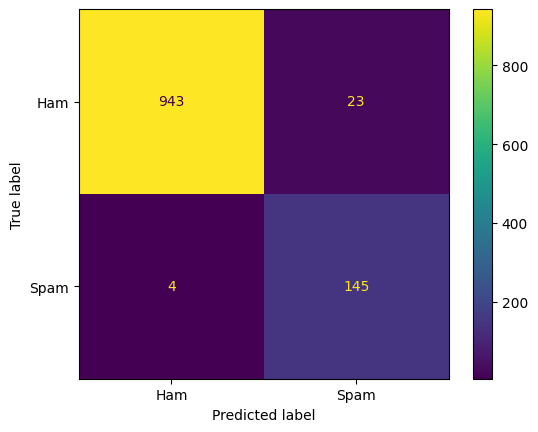

In [278]:
# Visualization confusion matrix
cm_bert = confusion_matrix(y_test, y_pred_bert)
fig3 = ConfusionMatrixDisplay(cm_bert, display_labels=["Ham", "Spam"])
fig3.plot()
plt.show()

In [279]:
# visualization classification report
print(classification_report(y_test, y_pred_bert, target_names=["Ham","Spam"]))

              precision    recall  f1-score   support

         Ham       1.00      0.98      0.99       966
        Spam       0.86      0.97      0.91       149

    accuracy                           0.98      1115
   macro avg       0.93      0.97      0.95      1115
weighted avg       0.98      0.98      0.98      1115



Save metrics to our dataframe with results

In [280]:
# compute recall and precision
recall_bert = model.evaluate([test_encodings, test_attention], y_test)[2]
precision_bert = model.evaluate([test_encodings, test_attention], y_test)[3]

 1/35 [..............................] - ETA: 1:30 - loss: 0.0176 - binary_accuracy: 1.0000 - recall: 1.0000 - precision: 1.0000

35/35 [==============================] - 58s 2s/step - loss: 0.0756 - binary_accuracy: 0.9758 - recall: 0.9732 - precision: 0.8631


In [281]:
# dataframe with metrics
bert_results = pd.DataFrame({"F1 score" : f1score_bert.round(4),
                              "Recall" : recall_bert,
                              "Precision" : precision_bert,
                              "AUC Score" : round(roc_auc_bert,4)},
                             index=["BERT model"])

model_results = pd.concat([model_results,bert_results])
model_results

,F1 score,Recall,Precision,AUC Score
Logistic regression,0.9011,0.825500,0.991900,0.912234
LSTM model,0.9597,0.959732,0.959732,0.976800
BERT model,0.9148,0.973154,0.863095,0.974700


### 6 - Conclusions

We have with Bert model a better performance in terms of recall, but it's to the detriment of Precision.
In a global point of view, our lstm model achieved the best performances, knowing that we can try to improve it.

Intuitively, Bert model has a better potential but it needs much more time computing machine.
We recognize that this first approach with this model was "simple" and we could try to optimize it by working on learning rate for example, or adjusting layers in order to improve the size of trainable params.

At least, the choice of our model will be linked also to our goal. Do we want to prioritize the correct detection of spam, perhaps to the detriment of the performance on ham detection for example ?